In [ ]:
"""
Implicit-PDF: Non-parametric representation of probability distributions on the rotation manifold
Kieran Murphy*, Carlos Esteves*, Varun Jampani, Srikumar Ramalingam, Ameesh Makadia
ICML 2021
implicit-pdf.github.io

This colab runs pose estimation on sample images from the Pascal3D+ test set, 
and on two sample images, using the trained IPDF model from the manuscript.
We show both how to output a single estimate of the pose, using gradient ascent
to find the rotation with maximal predicted probability, and how to output the 
entire, properly normalized distribution over SO(3).
"""

In [ ]:
!pip install tensorflow-graphics
!pip install healpy

In [ ]:
!wget https://storage.googleapis.com/gresearch/implicit-pdf/pretrained-pascal.zip
!unzip pretrained-pascal.zip
!wget https://kieranamurphy.com/s/pascal_sample.tfrecord
!wget https://kieranamurphy.com/s/airplane.jpg
!wget https://kieranamurphy.com/s/car.jpg

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from tensorflow_graphics.geometry import transformation
from google.colab import files

tfkl = tf.keras.layers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
#@title ImplicitSO3 class definition
class ImplicitSO3(tfkl.Layer):
  """Represents a distribution over SO(3) as an implicit function.
  Specifically, this is a fully connected network which takes as input
  a visual description vector and a query rotation, and outputs
  a single scalar which can be converted to a log likelihood via normalization.
  By querying many values we can build up a probability distribution over SO(3).
  The query format is a 3x3 rotation matrix, flattened and then positionally
  encoded in each component with multiple frequencies of sinusoids.
  Init args:
    len_visual_description: The length of the visual description vector, which
      is returned with the vision model at creation.
    number_fourier_components: The number of positional encoding frequencies for
      the rotation query.  If zero, positional encoding is not used.
    mlp_layer_sizes: A list of the number of units in each layer of the MLP.
    so3_sampling_mode: 'random' or 'grid'.  This is only efficacious during
     training, and determines how the normalization is computed.  'random'
     corresponds to sampling uniformly over the space of rotations, which is
     simple and less constrained but results in inexact normalization.  'grid'
     uses equivolumetric grids generated using healpix as a starting point.
     These grids are stored so each size only needs to be computed once per run.
    number_train_queries: The number of queries to use during training, which
      populate SO(3) to approximate the normalization of the likelihoods.  If
      so3_sampling_mode is 'grid', the nearest grid size in log space is used.
    number_eval_queries: The number of queries to use during evaluation, which
      is always a grid sampling (for proper normalization).
  """

  def __init__(self, len_visual_description,
               number_fourier_components, mlp_layer_sizes,
               so3_sampling_mode, number_train_queries,
               number_eval_queries, **kwargs):
    super().__init__(**kwargs)
    self.len_visual_description = len_visual_description
    # Rotations are represented as flattened 3x3 orthonormal matrices.
    self.len_rotation = 9
    self.number_fourier_components = number_fourier_components
    self.frequencies = tf.range(number_fourier_components, dtype=tf.float32)
    self.frequencies = tf.math.pow(2., self.frequencies)
    self.so3_sampling_mode = so3_sampling_mode
    self.number_train_queries = number_train_queries
    self.number_eval_queries = number_eval_queries
    if number_fourier_components == 0:
      self.len_query = self.len_rotation
    else:
      self.len_query = self.len_rotation * number_fourier_components * 2

    self.grids = {}

    # The grids will be populated on-demand.
    if self.so3_sampling_mode == 'grid':
      self.get_closest_available_grid(self.number_train_queries)
    self.get_closest_available_grid(self.number_eval_queries)

    input_visual = tfkl.Input(shape=(len_visual_description,))
    visual_embedding = tfkl.Dense(mlp_layer_sizes[0])(input_visual)
    input_query = tfkl.Input(shape=(None, self.len_query,))
    query_embedding = tfkl.Dense(mlp_layer_sizes[0])(input_query)

    # Broadcast sum to combine inputs.
    output = visual_embedding[:, tf.newaxis] + query_embedding

    output = tfkl.ReLU()(output)

    for num_units in mlp_layer_sizes[1:]:
      output = tfkl.Dense(num_units, 'relu')(output)
    output = tfkl.Dense(1)(output)
    self.implicit_model = tf.keras.models.Model(
        inputs=[input_visual, input_query],
        outputs=output)
    self.mlp_layer_sizes = mlp_layer_sizes

  def get_config(self):
    """For saving purposes."""
    config = super().get_config().copy()
    config.update({
        'len_visual_description': self.len_visual_description,
        'number_fourier_components': self.number_fourier_components,
        'mlp_layer_sizes': self.mlp_layer_sizes,
        'so3_sampling_mode': self.so3_sampling_mode,
        'number_train_queries': self.number_train_queries,
        'number_eval_queries': self.number_eval_queries,
    })
    return config

  def call(self, inp):
    return self.implicit_model(inp)

  def predict_probability(self, vision_description, rotation_matrix,
                          training=False):
    """Predict the probability of the rotation, given the vision description.
    Rotate the grids to make sure they contain the rotation matrix. It requires
    different queries per element in the batch, increasing the # of ops in the
    first MLP layer.
    Args:
      vision_description: The feature vectors of the batch of images.
      rotation_matrix: The query rotation matrices.
      training: True or False; determines how many queries to use for
        normalization and whether to use an equivolumetric grid.
    Returns:
      The probability density at the rotation given by rotation_matrix.
    """
    if training:
      query_rotations = self.generate_queries(
          self.number_train_queries, mode=self.so3_sampling_mode)
    else:
      query_rotations = self.generate_queries(
          self.number_eval_queries, mode='grid')
    delta_rot = tf.transpose(query_rotations[-1]) @ rotation_matrix
    query_rotations = tf.einsum('aij,bjk->baik', query_rotations, delta_rot)
    shape = query_rotations.shape
    query_rotations = tf.reshape(query_rotations,
                                 [shape[0], shape[1], self.len_rotation])
    query_rotations = self.positional_encoding(query_rotations)
    logits = self.implicit_model([vision_description, query_rotations],
                                 training=training)[Ellipsis, 0]

    probabilities = tf.nn.softmax(logits, axis=-1)
    # Scale by the volume per grid point.
    probabilities *= np.pi**2 / query_rotations.shape[1]
    # The final query rotation is the rotation we care about.
    return probabilities[:, -1]

  def predict_rotation(self, vision_descriptions, gradient_ascent=False):
    """Returns a predicted rotation given the vision description.
    The mode of the distribution is approximated, found either as the argmax
    over a set of samples, or by running gradient ascent on the probability with
    the sample argmax as the starting point.
    Args:
      vision_descriptions: The feature vectors for the images on which to run
        pose estimation.
      gradient_ascent: True or False; whether to perform gradient ascent after
        finding the argmax over the sample rotations, to squeeze out a little
        more performance.
    Returns:
      A tensor of rotations, shape [N, 3, 3] where N is the number of vision
      descriptions.
    """
    query_rotations = self.generate_queries(self.number_eval_queries,
                                            mode='grid')
    query_rotations_inp = tf.reshape(query_rotations, [-1, self.len_rotation])
    query_rotations_inp = self.positional_encoding(query_rotations_inp)
    logits = self.implicit_model([vision_descriptions, query_rotations_inp],
                                 training=False)[Ellipsis, 0]

    max_inds = tf.argmax(logits, axis=-1)
    max_rotations = tf.gather(query_rotations, max_inds)

    if not gradient_ascent:
      max_rotations = tf.reshape(max_rotations, [-1, 3, 3])
      return max_rotations

    # Perform gradient ascent, using the argmax rotations as starting seeds.
    # These parameters were found to work well for the scenarios tested, but
    # other cases may benefit from tuning these.
    update_step_size = 3e-5
    number_optimization_steps = 1000
    # Convert to quaternions to enforce normalization.
    query_quaternions = transformation.quaternion.from_rotation_matrix(max_rotations)
    query_quaternions = tf.Variable(query_quaternions, trainable=True)

    @tf.function
    def gradient_ascent_step(query_quaternions):
      with tf.GradientTape() as tape:
        query_rotations_inp = transformation.rotation_matrix_3d.from_quaternion(
            query_quaternions)
        query_rotations_inp = tf.reshape(query_rotations_inp,
                                         [-1, self.len_rotation])
        query_rotations_inp = self.positional_encoding(query_rotations_inp)
        logits = self.implicit_model([vision_descriptions, query_rotations_inp],
                                     training=False)
        logits = tf.linalg.diag_part(logits[Ellipsis, 0])
        # Maximize the network output without caring about normalization
        loss = -tf.reduce_sum(logits)
      grads = tape.gradient(loss, query_quaternions)
      query_quaternions.assign_add(-grads * update_step_size)
      query_quaternions.assign(transformation.quaternion.normalize(query_quaternions))
      return

    for _ in range(number_optimization_steps):
      gradient_ascent_step(query_quaternions)
    max_rotations = transformation.rotation_matrix_3d.from_quaternion(query_quaternions)
    return max_rotations

  def compute_loss(self, vision_description, rotation_matrix_gt):
    """Return the negative log likelihood of the ground truth rotation matrix.
    Args:
      vision_description: The vector representations of a batch of images.
      rotation_matrix_gt: The ground truth rotation matrices associated with the
        batch of images.
    Returns:
      A scalar, the loss of the batch.
    """
    probs = self.predict_probability(
        vision_description, rotation_matrix_gt, training=True)
    loss = -tf.reduce_mean(tf.math.log(probs))
    return loss

  def get_closest_available_grid(self, number_queries=None):
    if not number_queries:
      number_queries = self.number_eval_queries
    # HEALPix-SO(3) is defined only on 72 * 8^N points; we find the closest
    # valid grid size (in log space) to the requested size.
    # The largest grid size we consider has 19M points.
    grid_sizes = 72*8**np.arange(7)
    size = grid_sizes[
        np.argmin(np.abs(np.log(number_queries) - np.log(grid_sizes)))
        ]
    if self.grids.get(size) is not None:
      return self.grids[size]
    else:
      # logging.info('Using grid of size %d. Requested was %d.', size,
      #              number_queries)
      grid_created = False

      if not grid_created:
        self.grids[size] = np.float32(generate_healpix_grid(size=size))

      return self.grids[size]

  def generate_queries(self, number_queries, mode='random'):
    """Generate query rotations from SO(3).
    Args:
      number_queries: The number of queries.
      mode: 'random' or 'grid'; determines whether to generate rotations from
        the uniform distribution over SO(3), or use an equivolumetric grid.
    Returns:
      A tensor of rotation matrices, shape [num_queries, 3, 3].
    """
    if mode == 'random':
      return self.generate_queries_random(number_queries)
    elif mode == 'grid':
      return self.get_closest_available_grid(number_queries)

  def generate_queries_random(self, number_queries):
    """Generate rotation matrices from SO(3) uniformly at random.
    Args:
      number_queries: The number of queries.
    Returns:
      A tensor of shape [number_queries, 3, 3].
    """
    random_quaternions = transformation.quaternion.normalized_random_uniform(
        (number_queries,))
    random_rotations = transformation.rotation_matrix_3d.from_quaternion(
        random_quaternions)
    random_rotations = tf.cast(random_rotations, tf.float32)
    return random_rotations

  def positional_encoding(self, query_rotations):
    """This handles the positional encoding.
    Args:
      query_rotations: tensor of shape [N, len_rotation] or
        [bs, N, len_rotation].
    Returns:
      Tensor of shape [N, len_query] or [bs, N, len_query].
    """
    if self.frequencies.shape[0] == 0:
      return query_rotations

    def _enc(freq):
      return tf.concat(
          [tf.math.sin(query_rotations * freq),
           tf.math.cos(query_rotations * freq)], -1)
    query_rotations = tf.map_fn(_enc, self.frequencies)
    query_shape = tf.shape(query_rotations)
    if len(query_shape) == 4:
      query_rotations = tf.transpose(query_rotations, [1, 2, 0, 3])
      shape = tf.concat([query_shape[1:3], [self.len_query]], axis=0)
      query_rotations = tf.reshape(query_rotations, shape)
    else:
      query_rotations = tf.transpose(query_rotations, [1, 0, 2])
      query_rotations = tf.reshape(query_rotations, [-1, self.len_query])
    return query_rotations

  def output_pdf(self, vision_description, num_queries=None,
                 query_rotations=None):
    """Returns a normalized distribution over pose, given a vision description.
    Args:
      vision_description: A batch of feature vectors, representing the images on
        which to estimate the pose.
      num_queries: The number of queries to evaluate the probability for.
      query_rotations: If supplied, these rotations will be used to evaluate the
        distribution and normalize it, instead using the kwarg num_queries.
    Returns:
      Both the rotations and their corresponding probabilities.
    """

    if num_queries is None:
      num_queries = self.number_eval_queries
    if query_rotations is None:
      query_rotations = self.get_closest_available_grid(num_queries)

    query_rotations_enc = tf.reshape(query_rotations, [-1, self.len_rotation])
    query_rotations_enc = self.positional_encoding(query_rotations_enc)
    log_probabilities = self.implicit_model(
        [vision_description, query_rotations_enc], training=False)[Ellipsis, 0]
    probabilities = tf.nn.softmax(log_probabilities, axis=-1)
    return query_rotations, probabilities


def generate_healpix_grid(recursion_level=None, size=None):
  """Generates an equivolumetric grid on SO(3) following Yershova et al. (2010).
  Uses a Healpix grid on the 2-sphere as a starting point and then tiles it
  along the 'tilt' direction 6*2**recursion_level times over 2pi.
  Args:
    recursion_level: An integer which determines the level of resolution of the
      grid.  The final number of points will be 72*8**recursion_level.  A
      recursion_level of 2 (4k points) was used for training and 5 (2.4M points)
      for evaluation.
    size: A number of rotations to be included in the grid.  The nearest grid
      size in log space is returned.
  Returns:
    (N, 3, 3) array of rotation matrices, where N=72*8**recursion_level.
  """
  import healpy as hp  # pylint: disable=g-import-not-at-top

  assert not(recursion_level is None and size is None)
  if size:
    recursion_level = max(int(np.round(np.log(size/72.)/np.log(8.))), 0)
  number_per_side = 2**recursion_level
  number_pix = hp.nside2npix(number_per_side)
  s2_points = hp.pix2vec(number_per_side, np.arange(number_pix))
  s2_points = np.stack([*s2_points], 1)

  # Take these points on the sphere and
  azimuths = np.arctan2(s2_points[:, 1], s2_points[:, 0])
  tilts = np.linspace(0, 2*np.pi, 6*2**recursion_level, endpoint=False)
  polars = np.arccos(s2_points[:, 2])
  grid_rots_mats = []
  for tilt in tilts:
    # Build up the rotations from Euler angles, zyz format
    rot_mats = transformation.rotation_matrix_3d.from_euler(
        np.stack([azimuths,
                  np.zeros(number_pix),
                  np.zeros(number_pix)], 1))
    rot_mats = rot_mats @ transformation.rotation_matrix_3d.from_euler(
        np.stack([np.zeros(number_pix),
                  np.zeros(number_pix),
                  polars], 1))
    rot_mats = rot_mats @ tf.expand_dims(
        transformation.rotation_matrix_3d.from_euler([tilt, 0., 0.]), 0)
    grid_rots_mats.append(rot_mats)

  grid_rots_mats = np.concatenate(grid_rots_mats, 0)
  return grid_rots_mats

In [ ]:
#@title Display functionality
import io
def plot_to_image(figure):
  """Converts matplotlib fig to a png for logging with tf.summary.image."""
  buffer = io.BytesIO()
  plt.savefig(buffer, format='png')
  plt.close(figure)
  buffer.seek(0)
  image = tf.image.decode_png(buffer.getvalue(), channels=4)
  return image[tf.newaxis]


def visualize_model_output(vision_model,
                           model_head,
                           images,
                           rotation_matrices_gt=None):
  """Display distributions over SO(3).
  Args:
    vision_model: The model which produces a feature vector to hand to IPDF.
    model_head: The IPDF model.
    images: A list of images.
    rotation_matrices_gt: A list of [N, 3, 3] tensors, representing the ground
      truth rotation matrices corresponding to the images.
  Returns:
    A tensor of images to output via Tensorboard.
  """
  return_images = []
  num_to_display = 5

  vision_description = vision_model(tf.stack(images, 0), training=False)

  query_rotations, probabilities = model_head.output_pdf(vision_description)
  inches_per_subplot = 4
  canonical_rotation = np.float32(transformation.rotation_matrix_3d.from_euler([0.2]*3))
  for image_index in range(num_to_display):
    fig = plt.figure(figsize=(3*inches_per_subplot, inches_per_subplot))
    gs = fig.add_gridspec(1, 3)
    fig.add_subplot(gs[0, 0])
    plt.imshow(images[image_index])
    plt.axis('off')
    ax2 = fig.add_subplot(gs[0, 1:], projection='mollweide')
    return_fig = visualize_so3_probabilities(
        query_rotations,
        probabilities[image_index],
        rotation_matrices_gt[image_index],
        ax=ax2,
        fig=fig,
        display_threshold_probability=1e-2 / query_rotations.shape[0],
        canonical_rotation=canonical_rotation)
    return_images.append(return_fig)
  return tf.concat(return_images, 0)


def visualize_so3_probabilities(rotations,
                                probabilities,
                                rotations_gt=None,
                                ax=None,
                                fig=None,
                                display_threshold_probability=0,
                                to_image=True,
                                show_color_wheel=True,
                                canonical_rotation=np.eye(3)):
  """Plot a single distribution on SO(3) using the tilt-colored method.
  Args:
    rotations: [N, 3, 3] tensor of rotation matrices
    probabilities: [N] tensor of probabilities
    rotations_gt: [N_gt, 3, 3] or [3, 3] ground truth rotation matrices
    ax: The matplotlib.pyplot.axis object to paint
    fig: The matplotlib.pyplot.figure object to paint
    display_threshold_probability: The probability threshold below which to omit
      the marker
    to_image: If True, return a tensor containing the pixels of the finished
      figure; if False return the figure itself
    show_color_wheel: If True, display the explanatory color wheel which matches
      color on the plot with tilt angle
    canonical_rotation: A [3, 3] rotation matrix representing the 'display
      rotation', to change the view of the distribution.  It rotates the
      canonical axes so that the view of SO(3) on the plot is different, which
      can help obtain a more informative view.
  Returns:
    A matplotlib.pyplot.figure object, or a tensor of pixels if to_image=True.
  """
  def _show_single_marker(ax, rotation, marker, edgecolors=True,
                          facecolors=False):
    eulers = transformation.euler.from_rotation_matrix(rotation)
    xyz = rotation[:, 0]
    tilt_angle = eulers[0]
    longitude = np.arctan2(xyz[0], -xyz[1])
    latitude = np.arcsin(xyz[2])

    color = cmap(0.5 + tilt_angle / 2 / np.pi)
    ax.scatter(longitude, latitude, s=2500,
               edgecolors=color if edgecolors else 'none',
               facecolors=facecolors if facecolors else 'none',
               marker=marker,
               linewidth=4)

  if ax is None:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='mollweide')
  if rotations_gt is not None and len(tf.shape(rotations_gt)) == 2:
    rotations_gt = rotations_gt[tf.newaxis]

  display_rotations = rotations @ canonical_rotation
  cmap = plt.cm.hsv
  scatterpoint_scaling = 4e3
  eulers_queries = transformation.euler.from_rotation_matrix(display_rotations)
  xyz = display_rotations[:, :, 0]
  tilt_angles = eulers_queries[:, 0]

  longitudes = np.arctan2(xyz[:, 0], -xyz[:, 1])
  latitudes = np.arcsin(xyz[:, 2])

  which_to_display = (probabilities > display_threshold_probability)

  if rotations_gt is not None:
    # The visualization is more comprehensible if the GT
    # rotation markers are behind the output with white filling the interior.
    display_rotations_gt = rotations_gt @ canonical_rotation

    for rotation in display_rotations_gt:
      _show_single_marker(ax, rotation, 'o')
    # Cover up the centers with white markers
    for rotation in display_rotations_gt:
      _show_single_marker(ax, rotation, 'o', edgecolors=False,
                          facecolors='#ffffff')

  # Display the distribution
  ax.scatter(
      longitudes[which_to_display],
      latitudes[which_to_display],
      s=scatterpoint_scaling * probabilities[which_to_display],
      c=cmap(0.5 + tilt_angles[which_to_display] / 2. / np.pi))

  ax.grid()
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  if show_color_wheel:
    # Add a color wheel showing the tilt angle to color conversion.
    ax = fig.add_axes([0.86, 0.17, 0.12, 0.12], projection='polar')
    theta = np.linspace(-3 * np.pi / 2, np.pi / 2, 200)
    radii = np.linspace(0.4, 0.5, 2)
    _, theta_grid = np.meshgrid(radii, theta)
    colormap_val = 0.5 + theta_grid / np.pi / 2.
    ax.pcolormesh(theta, radii, colormap_val.T, cmap=cmap)
    ax.set_yticklabels([])
    ax.set_xticklabels([r'90$\degree$', None,
                        r'180$\degree$', None,
                        r'270$\degree$', None,
                        r'0$\degree$'], fontsize=14)
    ax.spines['polar'].set_visible(False)
    plt.text(0.5, 0.5, 'Tilt', fontsize=14,
             horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes)
  plt.show()
  if to_image:
    return plot_to_image(fig)
  else:
    return fig


In [ ]:
#@title Load pascal3d+ test set

all_pascal_classes = ['aeroplane', 'bicycle', 'boat', 'bottle',
                      'bus', 'car', 'chair', 'diningtable', 'motorbike',
                      'sofa', 'train', 'tvmonitor']

def load_pascal_eval(
    # pylint: disable=dangerous-default-value
    input_filename, img_dims=[224, 224], object_classes='all',
    serialized_example_dataset=None):
  # pylint: enable=dangerous-default-value
  """Create a tf.data.Dataset for Pascal3D+ evaluation.
  Args:
    input_filename: path to TFRecord file containing test set records.
      See parse_example below to see the expected format of the records.
    img_dims: [H, W] resolution of the cropped output image.
    object_classes: string containing a single class name from
      all_pascal_classes above. Dataset will be filtered to contain only images
      from that class. Can be 'all' (default), to return all classes.
    serialized_example_dataset: optional, a tf.data.Dataset that returns
      serialized tf.train.Example protos. If not None, this dataset will be used
      in place of the input_filename.
  Returns:
    tf.data.Dataset over Pascal3D+ test set.
  """

  def parse_example_real(example, context=1.166666):
    """Parse a single test example stored in a serialized tf.train.Example.
    See feature_description dict below for the expected fields.
    Args:
      example: a serialized tf.train.Example.
      context: factor for enlarging bounding box for cropping.
    Returns:
      im_crop: cropped image.
      R: ground truth rotation matrix.
      az: ground truth azimuth.
      el: ground truth elevation.
      th: ground truth tile angle.
      valid_box: boolean, true if input bounding box was valid.
      easy: boolean, true if the example is classified as easy (e.g. not
        occluded/truncated).
      class_one_hot: one hot vector of class label.
    """
    feature_description = {
        'image_buffer': tf.io.FixedLenFeature([], tf.string),
        'left': tf.io.FixedLenFeature([], tf.float32),
        'top': tf.io.FixedLenFeature([], tf.float32),
        'right': tf.io.FixedLenFeature([], tf.float32),
        'bottom': tf.io.FixedLenFeature([], tf.float32),
        'azimuth': tf.io.FixedLenFeature([], tf.float32),
        'elevation': tf.io.FixedLenFeature([], tf.float32),
        'theta': tf.io.FixedLenFeature([], tf.float32),
        'easy': tf.io.FixedLenFeature([], tf.int64),
        'class_num': tf.io.FixedLenFeature([], tf.int64),
    }
    fd = tf.io.parse_single_example(
        serialized=example, features=feature_description)
    im_enc = fd['image_buffer']
    im = tf.io.decode_jpeg(im_enc, channels=3)

    im = tf.image.convert_image_dtype(im, tf.float32)

    easy = fd['easy']
    class_num = tf.reshape(fd['class_num'], ())

    # Input bounding box pixel coordinates should be 1-based so subtract here.
    left = fd['left'] - 1.0
    top = fd['top'] - 1.0
    right = fd['right'] - 1.0
    bottom = fd['bottom'] - 1.0

    # Bounding box can be invalid at two points, input or after clip.
    valid_box = left < right and top < bottom
    im_crop = im
    if valid_box:
      mid_left_right = (right + left) / 2.0
      mid_top_bottom = (bottom + top) / 2.0
      # Add context.
      left = mid_left_right - context * (mid_left_right - left)
      right = mid_left_right + context * (right - mid_left_right)
      top = mid_top_bottom - context * (mid_top_bottom - top)
      bottom = mid_top_bottom + context * (bottom - mid_top_bottom)
      # Crop takes normalized coordinates.
      im_shape = tf.cast(tf.shape(im), tf.float32)
      y1 = tf.cast(top, tf.float32) / (im_shape[0] - 1.0)
      y2 = tf.cast(bottom, tf.float32) / (im_shape[0] - 1.0)
      x1 = tf.cast(left, tf.float32) / (im_shape[1] - 1.0)
      x2 = tf.cast(right, tf.float32) / (im_shape[1] - 1.0)
      y1 = tf.clip_by_value(y1, 0.0, 1.0)
      y2 = tf.clip_by_value(y2, 0.0, 1.0)
      x1 = tf.clip_by_value(x1, 0.0, 1.0)
      x2 = tf.clip_by_value(x2, 0.0, 1.0)
      valid_box = y1 < y2 and x1 < x2
      if valid_box:
        bbox = tf.reshape(tf.stack([y1, x1, y2, x2]), (1, 4))
        imb = tf.expand_dims(im, 0)
        im_crop = tf.image.crop_and_resize(
            image=imb, boxes=bbox, box_indices=[0], crop_size=img_dims)[0]

    # Inputs are in degrees, convert to rad.
    az = tf.reshape(fd['azimuth'], (1, 1)) * np.pi / 180.0
    el = tf.reshape(fd['elevation'], (1, 1)) * np.pi / 180.0
    th = tf.reshape(fd['theta'], (1, 1)) * np.pi / 180.0

    # R = R_z(th) * R_x(el−pi/2) * R_z(−az).
    rot1 = transformation.rotation_matrix_3d.from_euler(
        tf.concat([tf.zeros_like(az), tf.zeros_like(az), -az], -1))
    rot2 = transformation.rotation_matrix_3d.from_euler(
        tf.concat([el-np.pi/2.0, tf.zeros_like(el), th], -1))
    rot = tf.matmul(rot2, rot1)
    rot = tf.reshape(rot, (3, 3))

    class_one_hot = tf.one_hot(class_num, len(all_pascal_classes))

    return im_crop, rot, az, el, th, valid_box, tf.cast(easy,
                                                        tf.int32), class_one_hot

  def is_easy(im, rot, az, el, th, valid_box, easy, class_one_hot):
    del im, rot, az, el, th, valid_box, class_one_hot
    return tf.cond(easy > 0, lambda: True, lambda: False)

  def is_valid_box(im, rot, az, el, th, valid_box, easy, class_one_hot):
    del im, rot, az, el, th, easy, class_one_hot
    return valid_box

  if serialized_example_dataset is not None:
    data_real = serialized_example_dataset
  else:
    data_real = tf.data.TFRecordDataset(input_filename)

  data_real = data_real.map(parse_example_real, num_parallel_calls=4)
  data_real = data_real.filter(is_valid_box)
  # The common setting is to test only on the easy examples.
  data_real = data_real.filter(is_easy)
  # No augmentation since this is a data loader for the test set.

  # Filter by object class if all classes are not specified.
  if object_classes != 'all':
    class_ind = all_pascal_classes.index(object_classes)
    def _filter_by_class(im, rot, az, el, th, valid_box, easy, class_one_hot):
      del im, rot, az, el, th, valid_box, easy
      return tf.reduce_all(
          class_one_hot == tf.one_hot(class_ind, len(all_pascal_classes)))
    data_real = data_real.filter(_filter_by_class)

  data_real = data_real.map(lambda im, rot, *args: (im, rot))

  return data_real

In [ ]:
#@title Measure angular error between rotation matrices
def geodesic_distance_rotmats(r1s, r2s):
  """Computes batched geodesic distances between two corresponding sets of rotations.
  Args:
    r1s: [N, 3, 3] tensor
    r2s: [N, 3, 3] tensor
  Returns:
    N angular distances.
  """
  prod = tf.matmul(r1s, r2s, transpose_b=True)
  tr_prod = tf.linalg.trace(prod)
  angs = tf.math.acos(tf.clip_by_value((tr_prod-1.0)/2.0, -1.0, 1.0))
  return angs


In [ ]:
# Load the trained models
vision_base_fname = 'vision_base_os'
vision_base = tf.keras.models.load_model(vision_base_fname)

# The trained ipdf was saved as a Functional keras model, but this leaves out
# the class methods.  We load the weights and configuration, and port them over 
# to a new ImplicitSO3 instance.
ipdf_head_fname = 'ipdf_head'
ipdf_head_params = tf.keras.models.load_model(ipdf_head_fname).layers[2]
ipdf_head = ImplicitSO3.from_config(ipdf_head_params.get_config())
ipdf_head.implicit_model.set_weights(ipdf_head_params.implicit_model.get_weights())

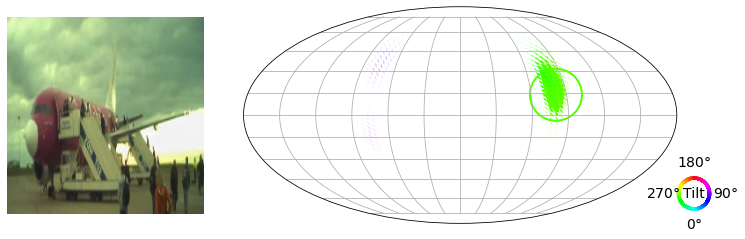

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9124821   0.40867463 -0.01901269]
 [ 0.05985233 -0.08737612  0.9943757 ]
 [ 0.40471488 -0.9084879  -0.10418928]]
Ground truth rotation: 
 [[ 0.9054933   0.4226314  -0.03827047]
 [ 0.0533582  -0.02392276  0.9982888 ]
 [ 0.42099267 -0.9059859  -0.04421275]]
Error: 3.75 deg


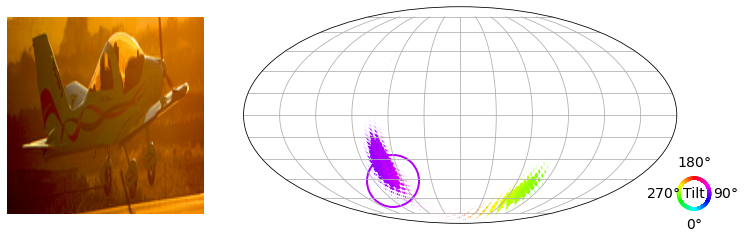

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.70317006 -0.6995758  -0.12706557]
 [-0.04734299 -0.1322453   0.9900857 ]
 [-0.7094438   0.70221424  0.05987096]]
Ground truth rotation: 
 [[-0.5381509  -0.829718   -0.14819475]
 [-0.0025693  -0.17421035  0.9847051 ]
 [-0.8428446   0.5303007   0.09161965]]
Error: 12.63 deg


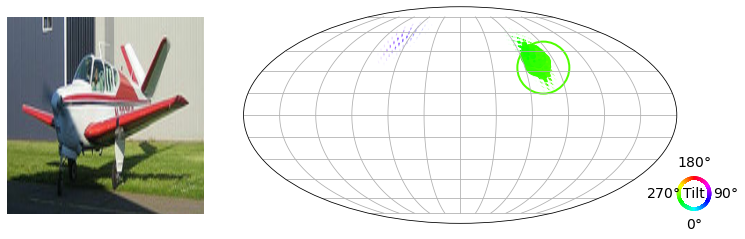

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 6.3539463e-01  7.7113676e-01  4.0271401e-02]
 [-2.5032014e-02 -3.1555414e-02  9.9918842e-01]
 [ 7.7178174e-01 -6.3588703e-01 -7.4696541e-04]]
Ground truth rotation: 
 [[ 0.7235275   0.6888487   0.04466914]
 [ 0.02510782 -0.09092875  0.9955408 ]
 [ 0.6898387  -0.71917963 -0.08308494]]
Error: 8.21 deg


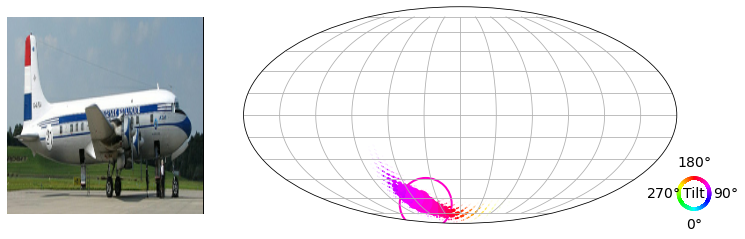

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.18659008 -0.9817078  -0.037871  ]
 [-0.05751383 -0.02756679  0.99796414]
 [-0.98075306  0.1883882  -0.05131829]]
Ground truth rotation: 
 [[-0.13866374 -0.98906326 -0.05026139]
 [-0.0596238  -0.04232205  0.99732333]
 [-0.98854303  0.14128937 -0.05310318]]
Error: 2.87 deg


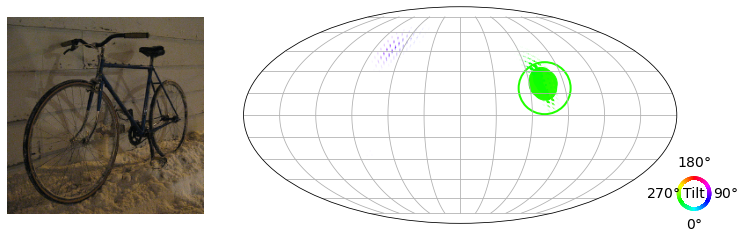

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.81043494  0.58559525  0.01653537]
 [-0.10079464  0.111579    0.98863065]
 [ 0.5770924  -0.80288744  0.14945239]]
Ground truth rotation: 
 [[ 0.84188837  0.53821427  0.03936065]
 [-0.11611025  0.10942748  0.98718995]
 [ 0.5270126  -0.835674    0.15461794]]
Error: 3.53 deg


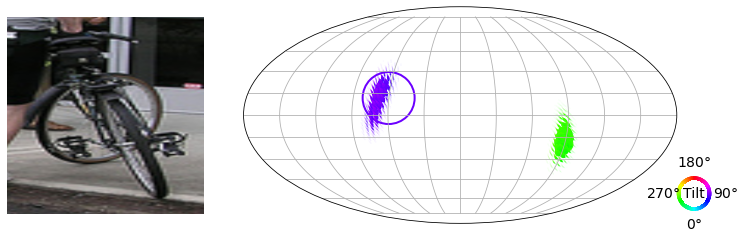

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9847662  -0.09476359 -0.14579242]
 [ 0.1581084   0.13903433  0.9775845 ]
 [-0.07236923 -0.98574317  0.15189922]]
Ground truth rotation: 
 [[-0.9589446   0.09016999 -0.26887646]
 [-0.2801467  -0.15382965  0.9475517 ]
 [ 0.04407956  0.9839745   0.17277494]]
Error: 179.56 deg


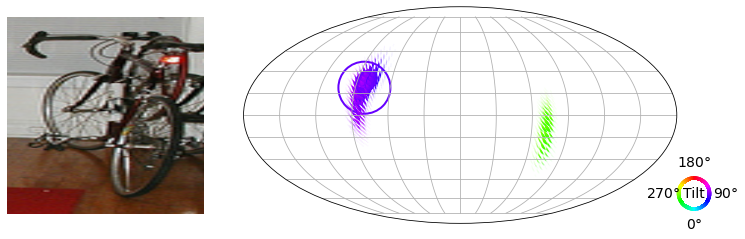

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.9695064   0.20165956  0.13925023]
 [ 0.11218017 -0.13999689  0.9837766 ]
 [ 0.21788256  0.9693989   0.11310577]]
Ground truth rotation: 
 [[-0.9802402   0.14653571  0.1328774 ]
 [ 0.1055688  -0.18054333  0.9778852 ]
 [ 0.16728522  0.97259     0.16150624]]
Error: 4.02 deg


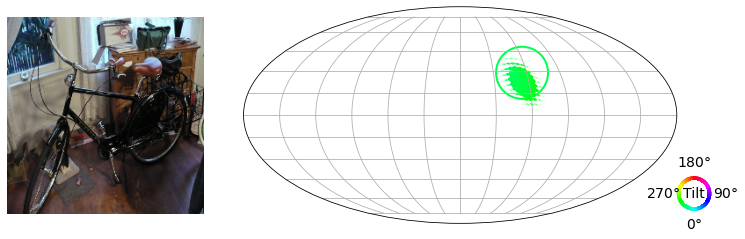

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.71743643  0.6733551   0.17854376]
 [-0.37503374  0.15735018  0.9135593 ]
 [ 0.587056   -0.72238064  0.36541963]]
Ground truth rotation: 
 [[ 0.5982676   0.80065227  0.03212183]
 [-0.37616488  0.24523263  0.89351046]
 [ 0.70751387 -0.54664147  0.44789198]]
Error: 13.60 deg


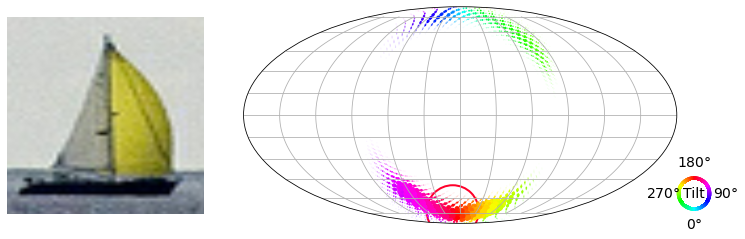

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.43412578 -0.9005833  -0.0220086 ]
 [-0.0184027  -0.03329134  0.99927616]
 [-0.9006642  -0.4334065  -0.03102577]]
Ground truth rotation: 
 [[ 0.11872467 -0.9915063  -0.05310107]
 [-0.07904732 -0.06274776  0.9948941 ]
 [-0.9897757  -0.11392098 -0.08582563]]
Error: 19.36 deg


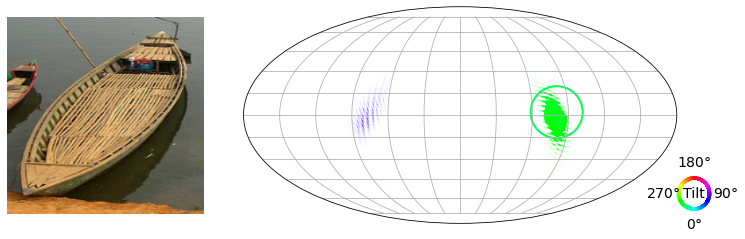

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.97212356  0.23336618 -0.02271502]
 [-0.06952475  0.37941968  0.922609  ]
 [ 0.22392422 -0.89531064  0.38506752]]
Ground truth rotation: 
 [[ 0.93914634  0.33094925 -0.0920689 ]
 [-0.14793012  0.6315254   0.76111263]
 [ 0.3100335  -0.70117635  0.6420521 ]]
Error: 19.19 deg


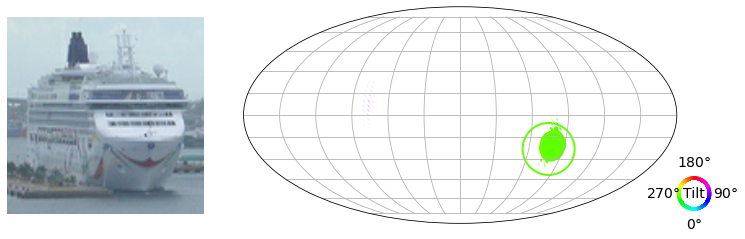

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.98518604 -0.17105278 -0.01222401]
 [ 0.01792797  0.03184146  0.99933195]
 [-0.17054933 -0.98474705  0.03443635]]
Ground truth rotation: 
 [[ 0.9783432  -0.2068064   0.00870418]
 [-0.00552645  0.01593844  0.99985766]
 [-0.2069157  -0.97825205  0.01445036]]
Error: 2.67 deg


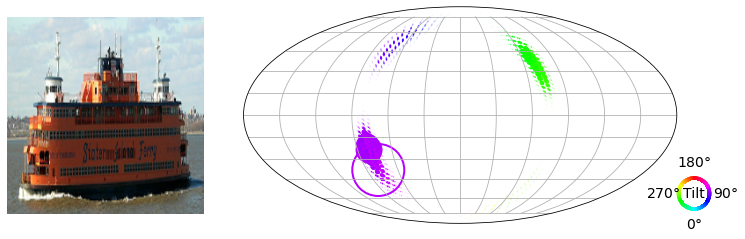

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.8225676  -0.56703246  0.04308313]
 [ 0.05031848  0.00288892  0.9987289 ]
 [-0.56643623  0.8236902   0.02615619]]
Ground truth rotation: 
 [[-0.6418465  -0.76611227  0.03324327]
 [ 0.04929768  0.00203788  0.99878204]
 [-0.7652469   0.64270353  0.03645955]]
Error: 15.46 deg


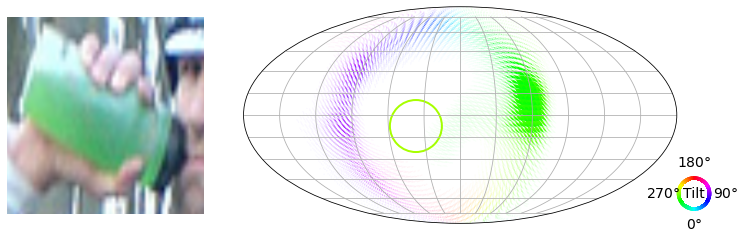

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.8208515   0.48306793  0.30470994]
 [-0.35209662  0.00793231  0.9359301 ]
 [ 0.44970074 -0.875547    0.17659783]]
Ground truth rotation: 
 [[-3.84068251e-01 -2.66535908e-01  8.83996665e-01]
 [-9.23304677e-01  1.10871226e-01 -3.67717266e-01]
 [ 5.01307582e-08 -9.57426846e-01 -2.88675964e-01]]
Error: 101.70 deg


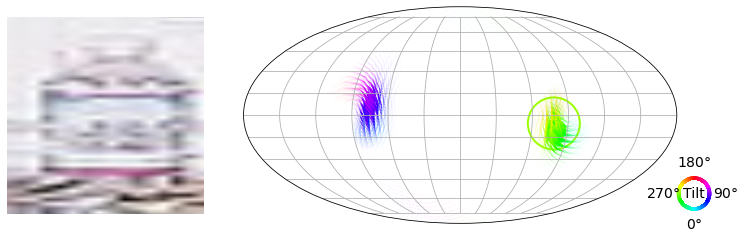

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9994015   0.02141735 -0.02716468]
 [ 0.02561564  0.06955361  0.99724936]
 [ 0.02324784 -0.9973483   0.06896335]]
Ground truth rotation: 
 [[ 0.99844545  0.05001128 -0.02460533]
 [ 0.03616868 -0.24547645  0.9687275 ]
 [ 0.04240729 -0.9681117  -0.24690372]]
Error: 18.29 deg


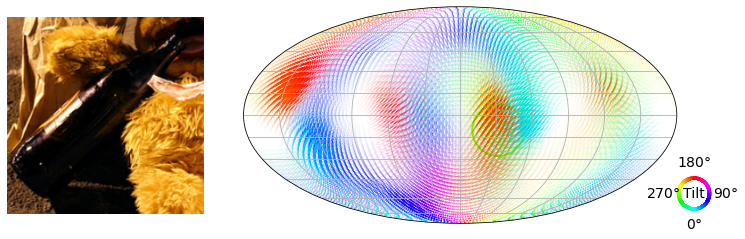

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.72116184  0.69004947 -0.0612962 ]
 [ 0.68469864  0.72343206  0.08850887]
 [ 0.10541914  0.02185979 -0.9941875 ]]
Ground truth rotation: 
 [[ 0.702768   -0.06184646  0.7087257 ]
 [-0.71141905 -0.06109439  0.7001074 ]
 [ 0.         -0.9962141  -0.08693393]]
Error: 177.20 deg


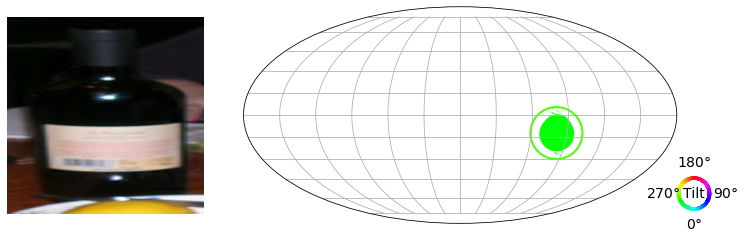

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.99953204  0.03016015  0.00510161]
 [-0.01593655  0.37110138  0.9284557 ]
 [ 0.02610914 -0.9281025   0.3714084 ]]
Ground truth rotation: 
 [[ 9.9954456e-01 -2.7440577e-03 -3.0051634e-02]
 [ 3.0176654e-02  9.0895161e-02  9.9540317e-01]
 [ 1.0428588e-07 -9.9585670e-01  9.0936579e-02]]
Error: 16.83 deg


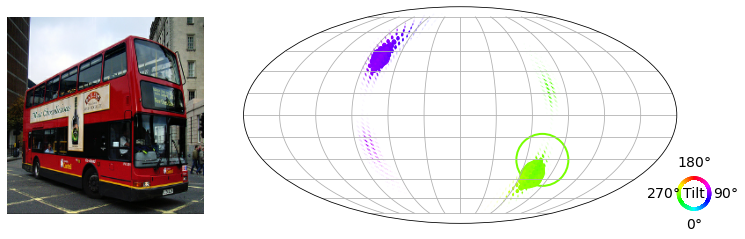

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.86154336 -0.5057473   0.04430209]
 [-0.06044728 -0.01554585  0.99805033]
 [-0.50407255 -0.86254156 -0.04396451]]
Ground truth rotation: 
 [[ 0.93829006 -0.34525487  0.02027162]
 [-0.02348767 -0.00513384  0.9997109 ]
 [-0.345051   -0.9384949  -0.01292626]]
Error: 10.40 deg


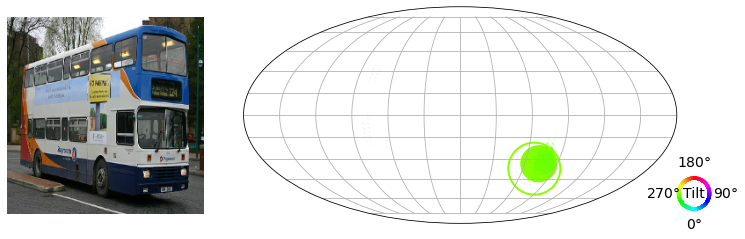

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 9.2435676e-01 -3.8152921e-01 -1.4574826e-04]
 [-4.9372017e-04 -1.5780926e-03  9.9999857e-01]
 [-3.8152891e-01 -9.2435539e-01 -1.6471148e-03]]
Ground truth rotation: 
 [[ 0.887872   -0.45738372  0.04983399]
 [-0.06227784 -0.0121587   0.99798477]
 [-0.45585608 -0.8891863  -0.03928024]]
Error: 5.97 deg


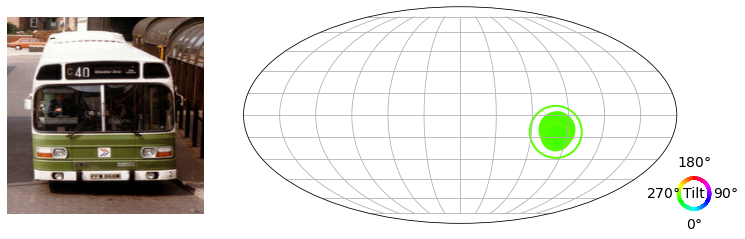

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.999242    0.00654002 -0.03837444]
 [ 0.03765408  0.08771652  0.99543357]
 [ 0.00987623 -0.996124    0.08740377]]
Ground truth rotation: 
 [[ 9.99429166e-01 -4.94730601e-04 -3.37801576e-02]
 [ 3.37837785e-02  1.46563295e-02  9.99321699e-01]
 [ 6.98056624e-07 -9.99892473e-01  1.46646770e-02]]
Error: 4.22 deg


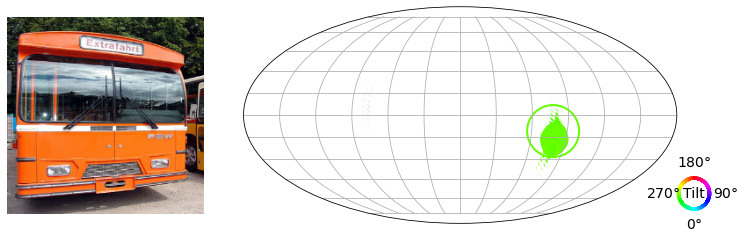

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.99477583 -0.10148717 -0.01101701]
 [ 0.01192742  0.00836825  0.99989384]
 [-0.10138419 -0.9948017   0.00953501]]
Ground truth rotation: 
 [[ 9.9999648e-01  8.8804947e-05 -2.6509217e-03]
 [ 2.6524088e-03 -3.3480749e-02  9.9943584e-01]
 [ 0.0000000e+00 -9.9943936e-01 -3.3480868e-02]]
Error: 6.33 deg


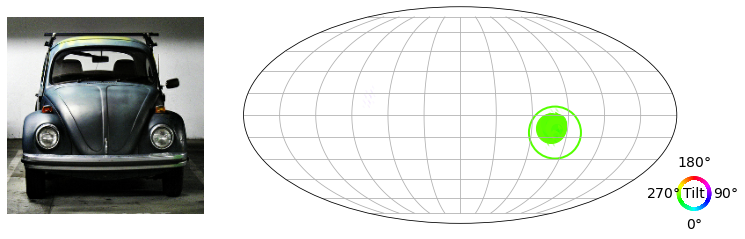

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 9.9814457e-01  5.9669584e-02  1.2121720e-02]
 [-1.2182863e-02  6.6107512e-04  9.9992543e-01]
 [ 5.9657127e-02 -9.9821788e-01  1.3867617e-03]]
Ground truth rotation: 
 [[ 9.9989206e-01 -8.3920063e-04 -1.4667612e-02]
 [ 1.4691600e-02  5.7114955e-02  9.9825948e-01]
 [ 0.0000000e+00 -9.9836725e-01  5.7121120e-02]]
Error: 4.96 deg


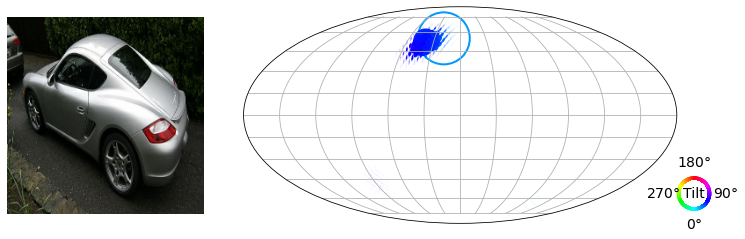

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.5806143   0.8055198  -0.11842564]
 [-0.2953945  -0.07287097  0.9525922 ]
 [ 0.75870216  0.58807105  0.28025615]]
Ground truth rotation: 
 [[-0.37909493  0.9249569   0.02723201]
 [-0.33855665 -0.16602606  0.9261828 ]
 [ 0.8612005   0.34189168  0.37609002]]
Error: 16.65 deg


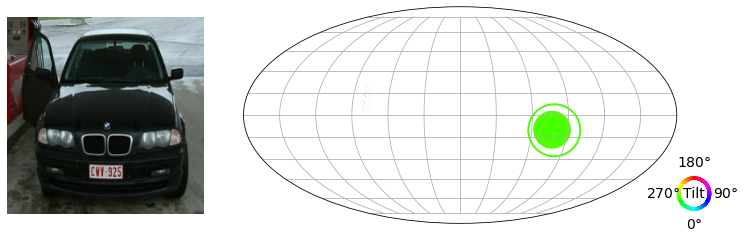

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9993266   0.02633789  0.02554676]
 [-0.02736551  0.07117939  0.9970879 ]
 [ 0.0244428  -0.99711555  0.07185221]]
Ground truth rotation: 
 [[ 0.99938023  0.03497456  0.00399885]
 [-0.0071058   0.08916714  0.99599135]
 [ 0.03447779 -0.9954024   0.0893604 ]]
Error: 1.66 deg


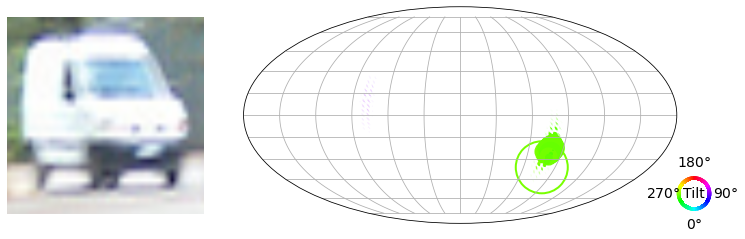

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.97572345 -0.21900007  0.00165811]
 [-0.00377139 -0.00923204  0.99995035]
 [-0.21897386 -0.97568125 -0.00983381]]
Ground truth rotation: 
 [[ 0.90371853 -0.4277603  -0.01771769]
 [ 0.02231801  0.00574205  0.9997344 ]
 [-0.42754498 -0.9038739   0.01473596]]
Error: 12.79 deg


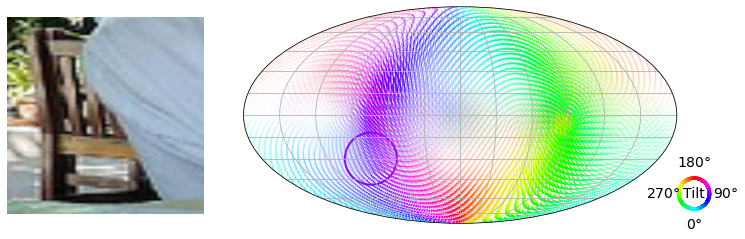

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9941285  -0.07601642 -0.07700612]
 [ 0.08808091  0.15513653  0.9839585 ]
 [-0.06285055 -0.984964    0.16092122]]
Ground truth rotation: 
 [[-0.74519664 -0.6645347   0.05545792]
 [ 0.06425174  0.01122537  0.99787056]
 [-0.6637421   0.7471731   0.0343324 ]]
Error: 134.19 deg


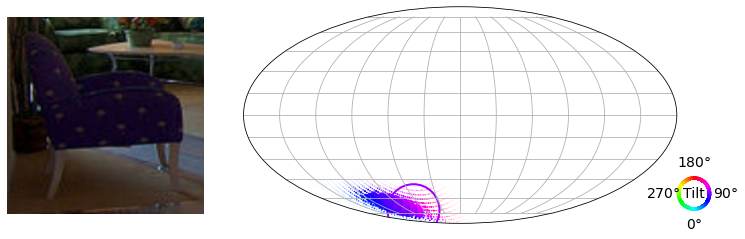

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.17414391 -0.9845139  -0.02016664]
 [ 0.20560053 -0.05638027  0.9770107 ]
 [-0.96301746  0.16599405  0.21223462]]
Ground truth rotation: 
 [[-0.14514793 -0.9828712  -0.1135619 ]
 [ 0.17973435 -0.13906075  0.97383654]
 [-0.97294796  0.1209394   0.19684009]]
Error: 5.65 deg


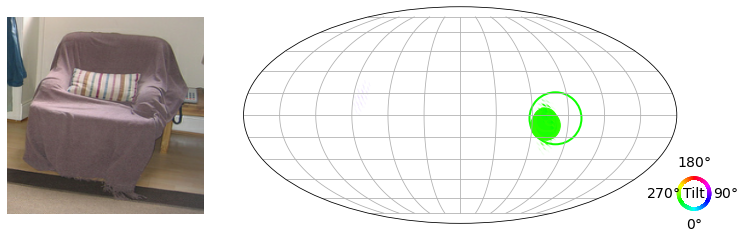

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.97679406  0.16645041  0.13478719]
 [-0.167889    0.20428461  0.96440715]
 [ 0.132991   -0.96465653  0.22748917]]
Ground truth rotation: 
 [[ 0.9755895   0.21939869 -0.00945233]
 [-0.05831325  0.300316    0.95205563]
 [ 0.21171844 -0.92826426  0.305779  ]]
Error: 9.82 deg


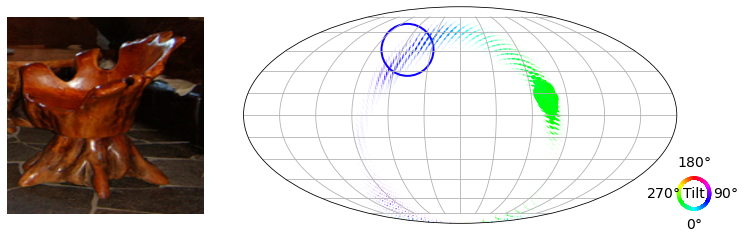

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 8.8053209e-01  4.7398651e-01  1.4072657e-04]
 [-1.6606461e-01  3.0822271e-01  9.3670756e-01]
 [ 4.4394347e-01 -8.2482439e-01  3.5011238e-01]]
Ground truth rotation: 
 [[-0.73402435  0.6788882  -0.01786377]
 [-0.18305229 -0.17245138  0.9678597 ]
 [ 0.65398794  0.71370256  0.25085554]]
Error: 109.00 deg


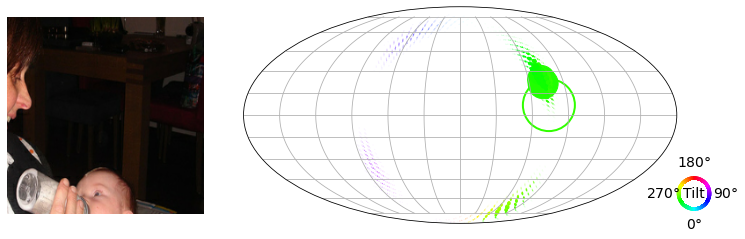

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.80436873  0.5933498   0.03044468]
 [-0.10414477  0.0903632   0.9904485 ]
 [ 0.5849314  -0.7998564   0.13447964]]
Ground truth rotation: 
 [[ 0.9355821   0.34820426  0.05865001]
 [-0.10137355  0.10575992  0.9892109 ]
 [ 0.33824465 -0.9314337   0.1342458 ]]
Error: 16.08 deg


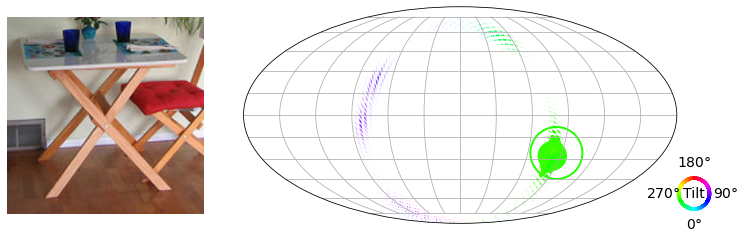

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.96661335 -0.25567204  0.01704253]
 [ 0.04185318  0.22315037  0.9738851 ]
 [-0.25279826 -0.9406571   0.2264008 ]]
Ground truth rotation: 
 [[ 0.97541034 -0.22000757 -0.01309142]
 [ 0.07119758  0.25832835  0.96343   ]
 [-0.20858    -0.9406716   0.26764014]]
Error: 3.65 deg


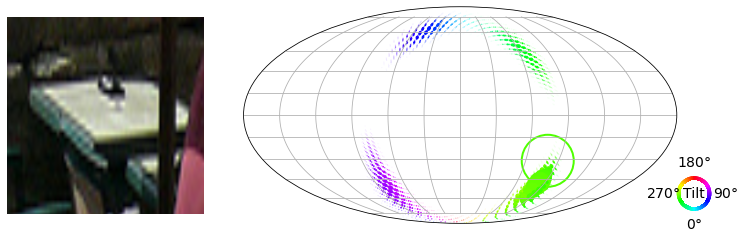

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.8023775  -0.5964116  -0.02198866]
 [ 0.09830414  0.09573311  0.99054104]
 [-0.5886651  -0.79694945  0.1354438 ]]
Ground truth rotation: 
 [[ 0.945047   -0.326575    0.01532615]
 [ 0.02861409  0.12932032  0.9911899 ]
 [-0.3256798  -0.9362825   0.13155843]]
Error: 17.69 deg


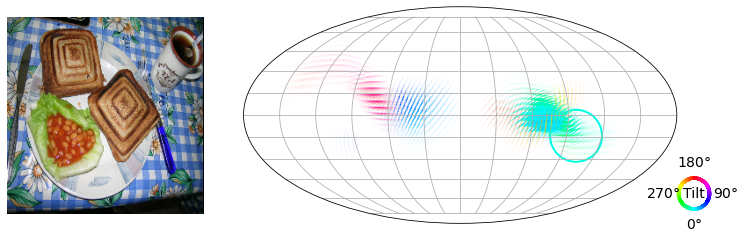

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.8555457   0.51034606 -0.08711201]
 [-0.48663273  0.85012996  0.20116559]
 [ 0.17672059 -0.12971482  0.9756761 ]]
Ground truth rotation: 
 [[ 1.          0.          0.        ]
 [ 0.          0.9659258   0.25881898]
 [ 0.         -0.25881898  0.9659258 ]]
Error: 31.53 deg


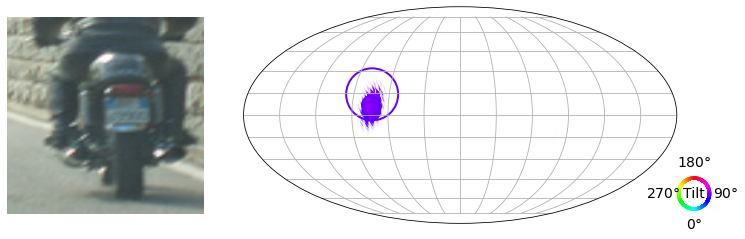

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.99688625 -0.054376   -0.05710793]
 [-0.04371458 -0.22165859  0.9741441 ]
 [-0.06562851  0.9736072   0.21859115]]
Ground truth rotation: 
 [[-0.99545884  0.09407271 -0.01456398]
 [-0.03097964 -0.17548205  0.9839951 ]
 [ 0.09001136  0.9799777   0.17759949]]
Error: 9.27 deg


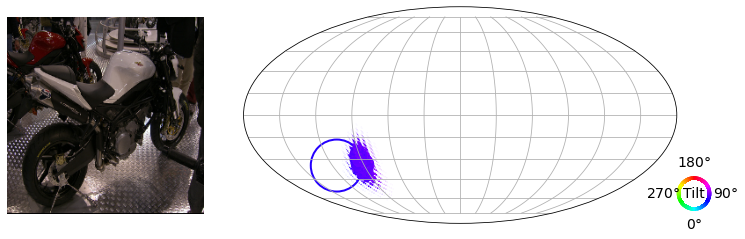

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.726529   -0.6845515   0.05953455]
 [ 0.26508117 -0.19928932  0.9434063 ]
 [-0.63394564  0.70119375  0.32625157]]
Ground truth rotation: 
 [[-0.5522516  -0.7870566   0.27488163]
 [ 0.5645602  -0.11045578  0.81796783]
 [-0.6134248   0.6069113   0.5053402 ]]
Error: 20.03 deg


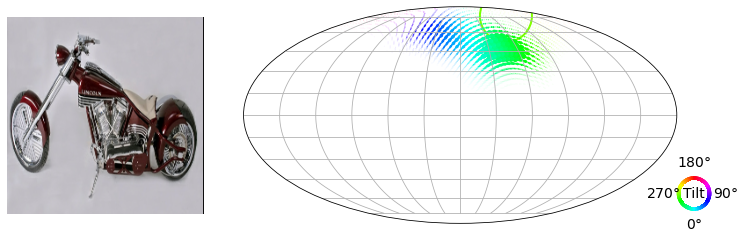

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.38298297  0.9170676   0.11095524]
 [-0.31308514  0.01585925  0.9495926 ]
 [ 0.86908096 -0.39841625  0.29319406]]
Ground truth rotation: 
 [[ 0.05591454  0.9976839   0.03873677]
 [ 0.22950521 -0.05060168  0.9719912 ]
 [ 0.9717     -0.04545815 -0.23180299]]
Error: 37.55 deg


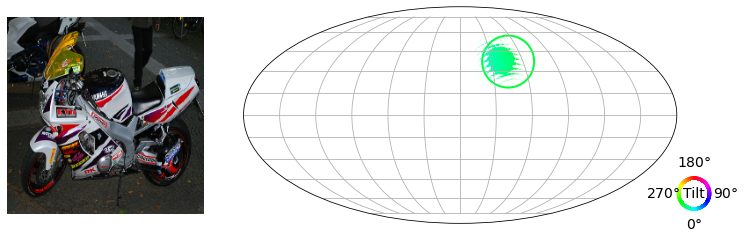

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.3468889   0.93332326  0.0926047 ]
 [-0.47407532  0.08928835  0.87594515]
 [ 0.8092716  -0.34775716  0.47343886]]
Ground truth rotation: 
 [[ 0.46441728  0.861266    0.20624572]
 [-0.3853682  -0.01314916  0.9226692 ]
 [ 0.7973756  -0.5079841   0.32579786]]
Error: 12.84 deg


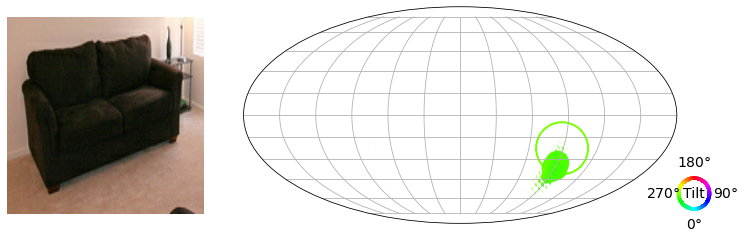

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9098281  -0.39138147 -0.13796145]
 [ 0.17267433  0.05474156  0.98345673]
 [-0.37735444 -0.918599    0.11738694]]
Ground truth rotation: 
 [[ 0.9561747  -0.19687875 -0.21672285]
 [ 0.20262401 -0.08938207  0.9751689 ]
 [-0.21136117 -0.97634506 -0.04557251]]
Error: 14.38 deg


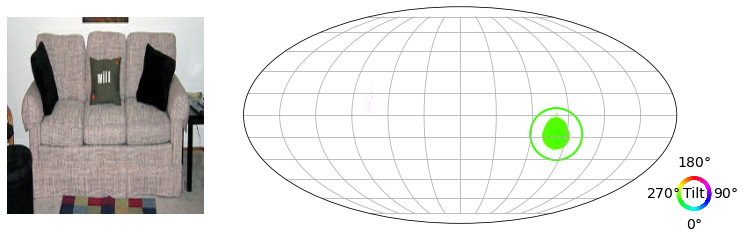

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9997875  -0.01374103 -0.01536489]
 [ 0.01601902  0.04883432  0.9986784 ]
 [-0.01297253 -0.99871236  0.04904407]]
Ground truth rotation: 
 [[ 0.9999432   0.00156317 -0.01054412]
 [ 0.01009861  0.1776852   0.98403555]
 [ 0.00341175 -0.98408616  0.17765932]]
Error: 7.49 deg


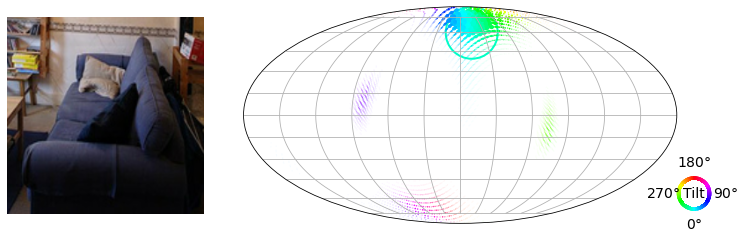

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.10329664  0.9926217   0.0634973 ]
 [-0.11086041 -0.07493067  0.99100727]
 [ 0.98845327  0.09532839  0.11778253]]
Ground truth rotation: 
 [[-0.0386523   0.98994344  0.13608032]
 [-0.28213474 -0.14145285  0.9488894 ]
 [ 0.9585958  -0.00171623  0.28476495]]
Error: 11.71 deg


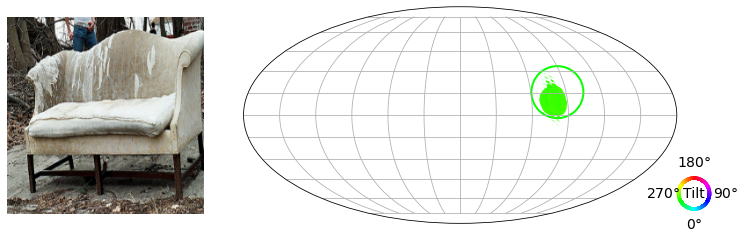

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 9.2740482e-01  3.7282974e-01 -3.0302733e-02]
 [ 2.9258430e-04  8.0287576e-02  9.9677163e-01]
 [ 3.7405908e-01 -9.2441970e-01  7.4349999e-02]]
Ground truth rotation: 
 [[ 0.8673999   0.47358802 -0.15274757]
 [ 0.01127996  0.28816938  0.95751303]
 [ 0.49748388 -0.8322697   0.24461603]]
Error: 14.44 deg


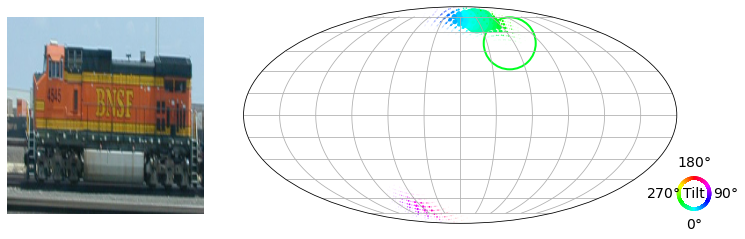

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.02765691  0.9995004   0.015302  ]
 [-0.08502972 -0.01760471  0.996223  ]
 [ 0.9959945   0.02625123  0.08547413]]
Ground truth rotation: 
 [[ 0.3687103   0.92490137  0.09279104]
 [-0.1663807  -0.03254569  0.9855243 ]
 [ 0.9145327  -0.37881163  0.14188582]]
Error: 24.13 deg


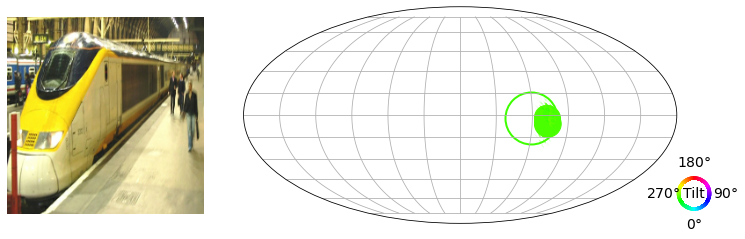

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9834804   0.14053671  0.11408652]
 [-0.11906414  0.02750701  0.99250555]
 [ 0.13634527 -0.9896934   0.04378545]]
Ground truth rotation: 
 [[ 0.92021906  0.20973006  0.3304696 ]
 [-0.3474152   0.04879013  0.9364413 ]
 [ 0.18027623 -0.9765413   0.11776102]]
Error: 14.01 deg


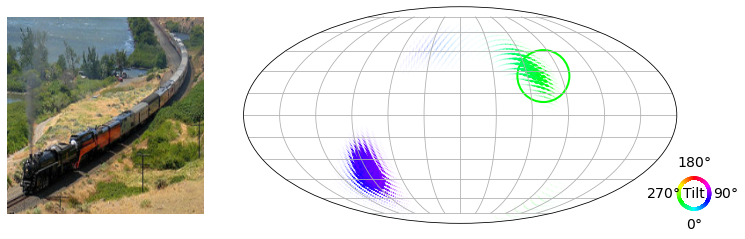

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[-0.6533387  -0.7556908  -0.04560694]
 [ 0.21686208 -0.24452674  0.9450807 ]
 [-0.72534084  0.60756737  0.3236395 ]]
Ground truth rotation: 
 [[ 0.7463169   0.6617956  -0.07097623]
 [-0.09693387  0.21357027  0.97210675]
 [ 0.6584944  -0.71861976  0.22354151]]
Error: 172.07 deg


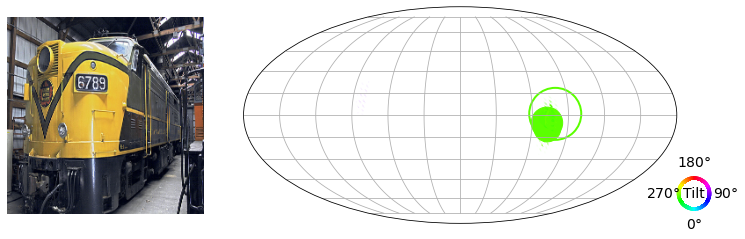

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.98917466  0.11598162  0.0898984 ]
 [-0.08729109 -0.02737749  0.9958066 ]
 [ 0.11795645 -0.992874   -0.01695693]]
Ground truth rotation: 
 [[ 0.9773907   0.21129176 -0.00794843]
 [ 0.00913418 -0.00463647  0.99994755]
 [ 0.21124382 -0.97741205 -0.00646162]]
Error: 7.87 deg


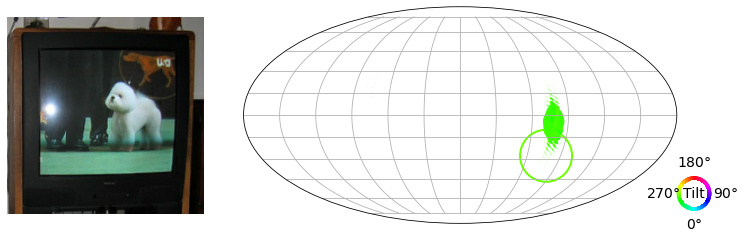

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.99405116  0.10886644  0.00322486]
 [-0.01807525  0.13570035  0.9905851 ]
 [ 0.10740385 -0.9847505   0.1368609 ]]
Ground truth rotation: 
 [[ 0.9573611  -0.2887463   0.00923257]
 [-0.00390209  0.01903095  0.9998113 ]
 [-0.2888675  -0.9572165   0.01709278]]
Error: 23.99 deg


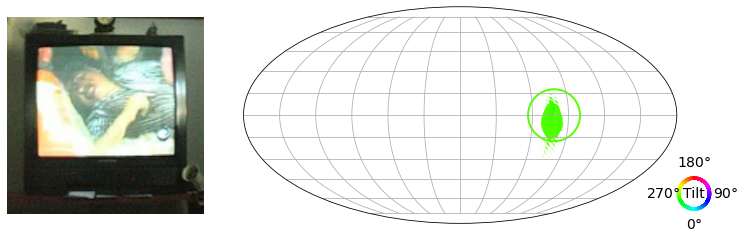

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9961083   0.0842901   0.0257583 ]
 [-0.02735923  0.0178932   0.99946564]
 [ 0.08378415 -0.9962807   0.02012968]]
Ground truth rotation: 
 [[ 0.9808862   0.19434969  0.0095138 ]
 [-0.00711813 -0.01302123  0.9998899 ]
 [ 0.19445217 -0.9808459  -0.01138893]]
Error: 6.72 deg


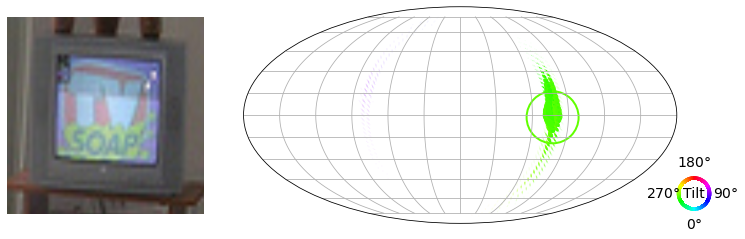

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9456546   0.32493752  0.0123699 ]
 [-0.00394182 -0.02658296  0.99963874]
 [ 0.32514897 -0.9453617  -0.02385747]]
Ground truth rotation: 
 [[ 0.9856782   0.16611935  0.02903211]
 [-0.02428823 -0.03051805  0.999239  ]
 [ 0.16687895 -0.9856333  -0.02604624]]
Error: 9.44 deg


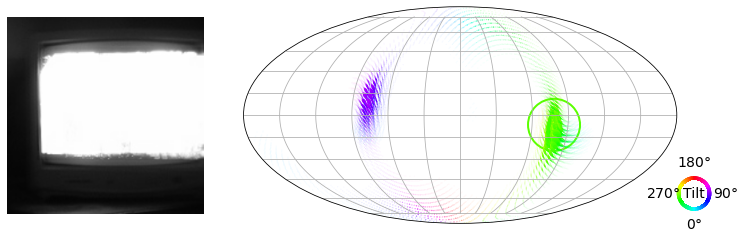

<Figure size 432x288 with 0 Axes>

Predicted rotation: 
 [[ 0.9999285   0.01112512 -0.00438758]
 [ 0.00369384  0.06162912  0.9980924 ]
 [ 0.0113743  -0.9980372   0.06158358]]
Ground truth rotation: 
 [[ 0.99642557  0.08439389  0.00370965]
 [-0.00447904  0.00892917  0.9999501 ]
 [ 0.08435655 -0.9963925   0.00927526]]
Error: 5.18 deg


In [ ]:
"""Pose estimation on samples from the Pascal3D+ test set.

We estimate the pose on 4 sample images from each class in the Pascal3D+ test 
set.  As in the paper, we use the rotation with maximal probability (found via
gradient ascent over the predicted distribution) as a single-valued estimate to
compare with the ground truth, and report the angular error.
We also visualize the entire predicted distribution, with the ground truth 
rotation displayed as a colored circle.
"""

pascal_sample_dataset = load_pascal_eval('pascal_sample.tfrecord')
num_examples_per_class = 4
for batch_ind, batched_examples in enumerate(pascal_sample_dataset.batch(num_examples_per_class)):
  images, rotation_gt = batched_examples

  vision_description = vision_base(images, training=False)
  prediction = ipdf_head.predict_rotation(vision_description, gradient_ascent=True)

  geodesic_errors = geodesic_distance_rotmats(prediction, rotation_gt)
  query_rotations, probabilities = ipdf_head.output_pdf(vision_description, num_queries=200_000)
  inches_per_subplot = 4
  # This rotation changes the projection axis for the display.
  # A little rotation is helpful to misalign the equivolumetric grid of
  # evaluation points from the projection axis, to make all points visible.
  canonical_rotation = np.float32(transformation.rotation_matrix_3d.from_euler([0.2]*3))
  for example_ind in range(num_examples_per_class):
    fig = plt.figure(figsize=(3*inches_per_subplot, inches_per_subplot))
    gs = fig.add_gridspec(1, 3)
    fig.add_subplot(gs[0, 0])
    plt.imshow(images[example_ind])
    plt.axis('off')
    ax2 = fig.add_subplot(gs[0, 1:], projection='mollweide')
    visualize_so3_probabilities(
        query_rotations,
        probabilities[example_ind],
        rotations_gt=rotation_gt[example_ind],
        ax=ax2,
        fig=fig,
        display_threshold_probability=1e-2 / query_rotations.shape[0],
        canonical_rotation=canonical_rotation)
    plt.show()
    print('Predicted rotation: \n', prediction[example_ind].numpy())
    print('Ground truth rotation: \n', rotation_gt[example_ind].numpy())
    print(f'Error: {np.rad2deg(geodesic_errors[example_ind]):.2f} deg')

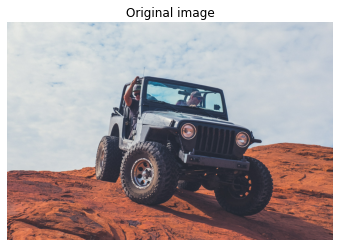

Predicted rotation: 
 [[ 0.89966804 -0.43039656  0.07318601]
 [-0.10101412 -0.04213059  0.9939926 ]
 [-0.42472762 -0.9016562  -0.08137965]]


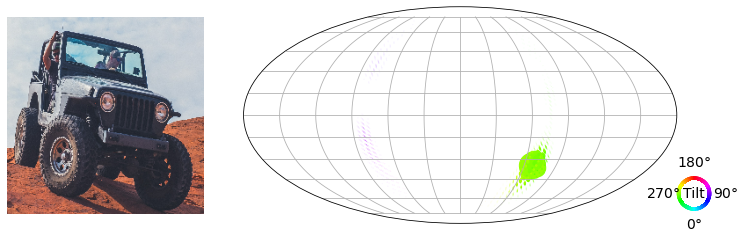

<Figure size 432x288 with 0 Axes>

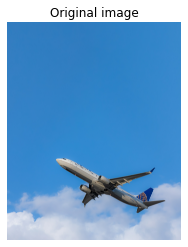

Predicted rotation: 
 [[ 0.69314396  0.714486    0.09518996]
 [ 0.3592708  -0.45694852  0.8137091 ]
 [ 0.6248807  -0.5298186  -0.57342505]]


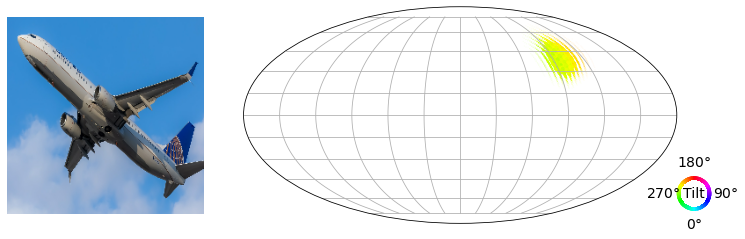

<Figure size 432x288 with 0 Axes>

In [ ]:
"""Estimate the pose for two images gathered from the web (credit: unsplash.com)

For a car and a plane, two categories from Pascal3d+, we estimate the pose for 
images outside the dataset.  All that must be done is cropping the object out 
(approximately) and then resizing to [224, 224, 3].
As there is no ground truth for these images, we only output the predicted 
distribution and the single-valued estimate.
"""
fnames = ['car.jpg', 
          'airplane.jpg']
crops = [[0.2, 0.25, 0.9, 0.85],
         [0.6, 0.25, 0.9, 0.87]]
for image_fname, image_crop in zip(fnames, crops):
  image_full = tf.image.decode_jpeg(tf.io.read_file(image_fname))
  plt.title('Original image')
  plt.imshow(image_full)
  plt.axis('off')
  plt.show()

  image_inp = tf.image.crop_and_resize(np.float32(image_full[tf.newaxis])/255., [image_crop], [0], [224, 224])

  vision_description = vision_base(image_inp)
  predicted_rotation = ipdf_head.predict_rotation(vision_description, gradient_ascent=True)
  print('Predicted rotation: \n', predicted_rotation[0].numpy())
  query_rotations, probabilities = ipdf_head.output_pdf(vision_description, num_queries=200_000)

  fig = plt.figure(figsize=(3*inches_per_subplot, inches_per_subplot))
  gs = fig.add_gridspec(1, 3)
  fig.add_subplot(gs[0, 0])
  plt.imshow(image_inp[0])
  plt.axis('off')
  ax2 = fig.add_subplot(gs[0, 1:], projection='mollweide')
  visualize_so3_probabilities(
      query_rotations,
      probabilities[0],
      ax=ax2,
      fig=fig,
      display_threshold_probability=1e-2 / query_rotations.shape[0],
      canonical_rotation=canonical_rotation)
  plt.show()